In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
from CoExBO._utils import TensorManager
tm = TensorManager()
warnings.filterwarnings('ignore')

## 1. Problem definition
Let's get started with the toy example of two-dimensional Branin function.<br>
More details can be found [here](https://www.sfu.ca/~ssurjano/branin.html)<br>
- bounds: -2 from 3
- variable type: continuous
- ground truth X: [-1.02543108, -1.02543108]
- ground truth Y: 10.6043
- optimisation: maximisation

In [2]:
class Benchmark():
    def __init__(self, X_data, Y_data):
        self.X_data = X_data
        self.Y_data = Y_data
    def find_closest_point(self, query, loop = False):
        y_set = []
        query = query.squeeze()
        if len(query.shape) > 1:
            for X in query:
                X = X.detach().numpy()
                distances = np.linalg.norm(self.X_data - X, axis=1)
                closest_index = np.argmin(distances)
                y = self.Y_data[closest_index]
                y_set.append(y)
            return torch.tensor(y_set, dtype=torch.float32).squeeze()
        else:
            X = query.detach().numpy()
            distances = np.linalg.norm(self.X_data - X, axis=1)
            closest_index = np.argmin(distances)
            y = self.Y_data[closest_index]
            return torch.tensor(y, dtype=torch.float32)


In [3]:
lower_limit = 0
upper_limit = 1
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

We assume we have a prior knowledge about this function.<br>
And we try to guide BO to rectify their recommendatation with help of explanation features.<br>
<br>
As we can see, the global maximum is at around [-1, -1].<br>
We can also observe there are 9 peaks for this function.<br>
We can expect BO can be stuck in one of these local maxima.<br>
<br>
Let's try to shepherd BO go to [-1, -1].

## 2. Define domain
Next, we define the domain of interest.
We set domain as uniform distribution bounded -2 from 3.

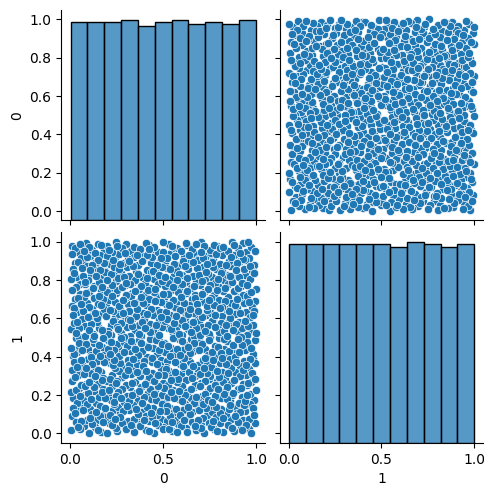

In [4]:
import seaborn as sns
import pandas as pd

# set bounds
n_dims = 2                          # number of dimensions
mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set domain
from CoExBO._prior import Uniform    # Import prior from SOBER libraries
domain = Uniform(bounds)

# visualise domain
samples = domain.sample(1000)
sns.pairplot(pd.DataFrame(tm.numpy(samples)))
plt.show()

## 3. Preferential learning
Next, we try to learn the prior knowledge of human user.<br>
For simplicity, human selection process is automatically generated with 60% accuracy via simulation.

In [5]:
from CoExBO._coexbo import CoExBOwithSimulation, StateManager
n_init_pref = 100      # number of initial random samples for preferential learning
n_init_obj = 2        # number of initial random samples for objective function

## 4. Run CoExBO
Now, we will collaborate with BO for faster convergence.<br>

In [6]:
n_iterations = 10     # number of iterations
seed = 0              # random seed for reproduce the results

# initial setting
torch.manual_seed(seed)
state = StateManager(n_dims=n_dims)

In [7]:
from importlib.machinery import SourceFileLoader
def load_module(filename):
    module_name = os.path.splitext(os.path.basename(filename))[0]
    return SourceFileLoader(module_name, filename).load_module(module_name)

In [9]:
import os.path as osp
import torch
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.utils import t_batch_mode_transform
from CoExBO._utils import TensorManager

In [11]:
results = []
import numpy as np
dataset = "glmnet"
X_test = np.load(f'./datasets/{dataset}/X_test.npz')
y_test = np.load(f'./datasets/{dataset}/y_test.npz')
X_test = np.array([X_test[key].astype('float32') for key in X_test.keys()])
y_test = np.array([y_test[key].astype('float32') for key in y_test.keys()])

X_validation = np.load(f'./datasets/{dataset}/X_validation.npz')
y_validation = np.load(f'./datasets/{dataset}/y_validation.npz')
X_validation = np.array([X_validation[key].astype('float32') for key in X_validation.keys()])
y_validation = np.array([y_validation[key].astype('float32') for key in y_validation.keys()])

for i in range(len(X_test)):
    benchmark = Benchmark(X_test[i], y_test[i])
    benchmark2 = Benchmark(X_validation[i], X_validation[i])
    true_function = benchmark.find_closest_point
    true_function2 = benchmark.find_closest_point
    coexbo = CoExBOwithSimulation(domain, true_function, sigma=0.1, hallucinate=False)
    coexbo2 = CoExBOwithSimulation(domain, true_function2, sigma=0.1, hallucinate=False)
    dataset_obj, _ = coexbo.initial_sampling(n_init_obj, n_init_pref)
    _, dataset_duel = coexbo.initial_sampling(n_init_obj, n_init_pref)
    # print("dataset_obj: ", dataset_obj)
    # print("dataset_duel: ", dataset_duel)
    #print(dataset_duel)
    #_, dataset_duel = coexbo.initial_sampling(n_init_obj, n_init_pref)
    for t in range(n_iterations):
        beta, gamma = state(t)
        result, dataset_obj, dataset_duel = coexbo(
            dataset_obj, dataset_duel, beta, gamma, model_TPN = None, lower_limit= lower_limit, upper_limit=upper_limit
        )
        print(f"{len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
        results.append(result)

results = torch.tensor(results)

0) parameters: beta 5.657e-01 gamma 0.000e+00


InputDataError: Expected all inputs to share the same dtype. Got torch.float64 for X, torch.float32 for Y, and None for Yvar.

# Results
[overhead(s), best observation, Euclidean distance between the pairwise candidates, correct_answer_rate]

In [ ]:
results

tensor([[1.4977, 0.9904, 0.0000, 0.5644],
        [1.4999, 0.9904, 0.0000, 0.5637],
        [2.5112, 0.9904, 0.0000, 0.5631],
        [1.5791, 0.9904, 0.0000, 0.5625],
        [1.4995, 0.9904, 0.0000, 0.5619],
        [1.5089, 0.9904, 0.0000, 0.5613],
        [1.4690, 0.9904, 0.0000, 0.5607],
        [1.4473, 0.9904, 0.0000, 0.5602],
        [1.4948, 0.9904, 0.0000, 0.5596],
        [1.5132, 0.9904, 0.0000, 0.5591],
        [1.5298, 0.7677, 0.0000, 0.5198],
        [1.5720, 0.7677, 0.0000, 0.5196],
        [1.5656, 0.7677, 0.0000, 0.5194],
        [1.5994, 0.7677, 0.0000, 0.5192],
        [1.4089, 0.7677, 0.0000, 0.5190],
        [1.3624, 0.7677, 0.0000, 0.5189],
        [1.4135, 0.7677, 0.0000, 0.5187],
        [1.4428, 0.7677, 0.0000, 0.5185],
        [1.4684, 0.7677, 0.0000, 0.5183],
        [1.5631, 0.7677, 0.0000, 0.5182],
        [1.5554, 1.0000, 0.0000, 0.5000],
        [1.5788, 1.0000, 0.0000, 0.5000],
        [1.5760, 1.0000, 0.0000, 0.5000],
        [1.6992, 1.0000, 0.0000, 0